# Scoring Analysis

## Motivation: Determine a way to evaluate speech detection numerically.

Given a (fabricated) y_pred that indicated whether a give sample was speech or not, it was compared
to a ground truth y. I manually fabricated the y_pred so that I could compare the various scoring approaches
under various scenarios.

One of the more challenging scenarios was that I wanted to penalize the prediction when they were "too simple".
For example, predicting continuous speech when in fact there were short bursts of silence.

Since time series data is not independent, many common scoring methods are not suitable, e.g.:
* F1, MSE, Recall, Precision, etc.

One approach was to process the time series data such that series dependency was embedded in each element so
that typical scoring methods could be used. Specifically, by counting the duration between event transitions and then
use the typical scoring methods on that data.

Another approach was to convolve using a generic boolean shape (this make it easier to convert to a standard scale)

## Results

Adding a penalty for differences in variance combined with convolution seemed to offer the best result.

Convolution generally performed better than the typical scoring method, but just convolving over the general shape
did not sufficiently penalize over simplistic models.

The standard scoring methods did not perform particularly well. Processing the data to embed the series dependency did
not significantly improve the performance either.


## Strategies yet to be considered: Dynamic Time Warping
My initial attempts at using DTW did not result in a useful
metric. The resultant DTW path was trivial. More investigation is needed to determine if it was due to poor
implementation or whether the data was not well suited for DTW.


## Create Sample Actual vs Prediction data sets and Scorers


In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
import pandas as pd
from display import Disp

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')
import numpy as np

from sklearn.metrics import f1_score, precision_score

from scorers import bconvolve_score, conv_var, ticker_r2, r2_score_wrapper, ticker_mse, mse_wrapper

def make_from_runs(runs):
    return np.concatenate([np.repeat(val, num) for num, val in runs])

# Scoring strategies for comparison
SCORE_FNS = {
    'conv': bconvolve_score,
    'conv_var': conv_var,
    'tick r2': ticker_r2,
    'r2': r2_score_wrapper,
    'prec': precision_score,
    'f1': f1_score,
    'tick mse': ticker_mse,
    'mse': mse_wrapper,
}

SCORE_NAMES = list(SCORE_FNS.keys())


# Make Sample data sets (y_sims) to investigate scoring strategies
y_sims = {}
y1 = [
    {
        'id': '0-0',
        'vals': make_from_runs([(8, False), (112, True), (8, False)]),
        'manual score': 1.0
    },
    {
        'id': '0-1L',
        'vals': make_from_runs([(7, False), (113, True), (8, False)]),
        'manual score': 0.99
    },
    {
        'id': '0-1R',
        'vals': make_from_runs([(8, False), (113, True), (7, False)]),
        'manual score': 0.99
    },
    {
        'id': '0-2^',
        'vals': make_from_runs([(8, False), (54, True), (4, False), (54, True),(8, False)]),
        'manual score': 0.90
    },
    {
        'id': '0-3^^^',
        'vals': make_from_runs([(8, False), (16, True), (4, False), (8, True), (16, False),(8, True),
                                   (8, False),
                                   (8, True), (16, False), (8, True), (4, False), (16, True), (8, False)]),
        'manual score': 0.30
    }
]

y2 = [
    {
        'id': '1-0',
        'vals': make_from_runs([(8, False), (54, True), (4, False), (54, True),(8, False)]),
        'manual score': 1.0
    },
    {
        'id': '1-1_',
        'vals': make_from_runs([(8, False), (112, True), (8, False)]),
        'manual score': 0.5
    },
    {
        'id': '1-2L',
        'vals': make_from_runs([(8, False), (52, True), (4, False), (56, True), (8, False)]),
        'manual score': 0.99
    },
    {
        'id': '1-3LL',
        'vals': make_from_runs([(8, False), (50, True), (4, False), (58, True), (8, False)]),
        'manual score': 0.97
    },
    {
        'id': '1-4^^',
        'vals': make_from_runs([(8, False), (52, True), (2, False),(4, True), (2,False), (52, True), (8, False)]),
        'manual score': 0.7
    },
    {
        'id': '1-5^^^',
        'vals': make_from_runs([(8, False), (16, True), (4, False), (8, True), (16, False),(8, True),
                                   (8, False),
                                   (8, True), (16, False), (8, True), (4, False), (16, True), (8, False)]),
        'manual score': 0.55
    }
]

y_sims['all speech'] = y1
y_sims['one dip'] = y2

scores = {}
score_names = ['man'] + SCORE_NAMES

## Visualize the Sample Data

Concise plots of the sample (boolean) data. Red X -> False, Green Dots -> True
The labels are a bit cryptic, but identify the various scenarios.

/Users/dev/Projects/korean-ml/scorers.py:164: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))
/Users/dev/Projects/korean-ml/scorers.py:164: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


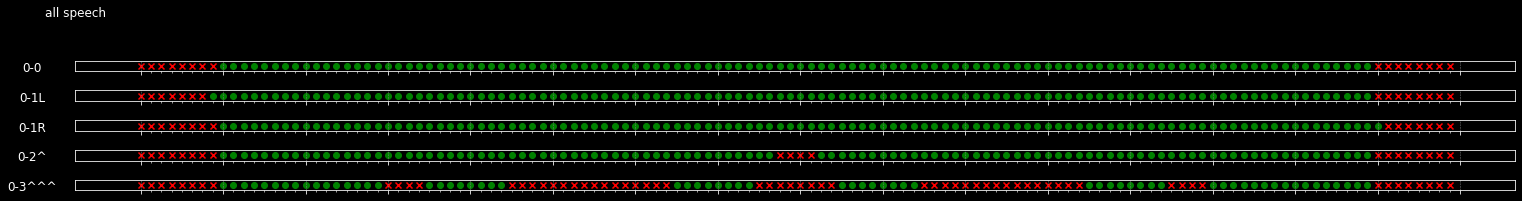

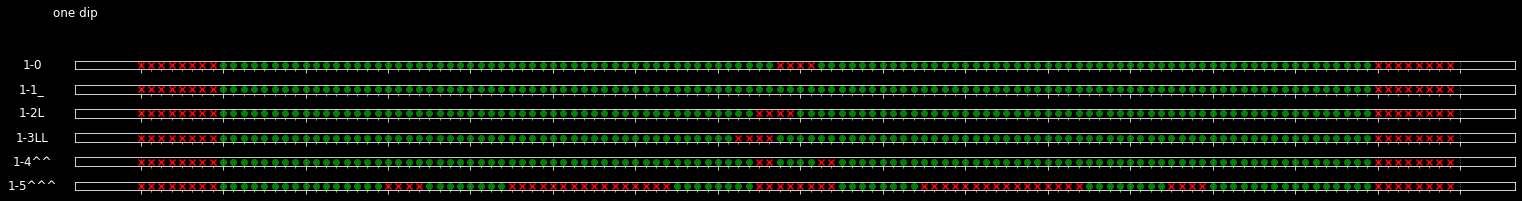

In [2]:
for name, ys in y_sims.items():

    plt_rows = len(ys)
    plt_cols = 1
    fig, full_axs  = plt.subplots(plt_rows, plt_cols, squeeze=False, figsize=(20,1.5))
    fig.suptitle(f'{name}', x=0, y=1.7)
    axs = full_axs[:,0]
    base_data = ys[0]['vals']

    scores[name] = {}
    for i, data in enumerate(ys):
        y = data['vals']
        data_id = data['id']
        major_ticks = np.linspace(0,len(y),1+len(y)//8)
        minor_ticks = np.linspace(0,len(y),len(y)+1)

        y_val = np.repeat(-i, len(y)) # negative so our base plot is on top
        xT = np.where(y == True)[0]
        xF = np.where(y == False)[0]

        # calculate scores
        score_list = [data['manual score']] + [SCORE_FNS[score_name](base_data, y) for score_name in SCORE_NAMES]
        # store for later use
        scores[name][data_id] = score_list

        # Plot sample data
        title = f'{data_id}'
        # x=-0.1, y=0.5
        axs[i].set_title(f'{title}', position=(-0.03,0), y=-0.6)
        axs[i].set_xticks(major_ticks)
        axs[i].set_xticks(minor_ticks, minor=True)
        axs[i].set_xticklabels([])
        axs[i].set_yticks([])
        axs[i].set_yticklabels([])
        axs[i].grid(axis='x', color='gray', linestyle='--', linewidth=0.5)

        axs[i].scatter(xT, y_val[xT], marker='o', color='green')
        axs[i].scatter(xF, y_val[xF], marker='x', color='red')


    fig.subplots_adjust(left=0.0,
                    bottom=0.0,
                    right=1.0,
                    top=1.2,
                    wspace=0.,
                    hspace=1.8)

# Scorer Results

All scoring methods were converted to a scale between 0 (bad) and 1 (good).

Caveat: This is an attempt to get a **rough** comparison between different scoring stragies. There are several "hacks"
to get the data to be apples to apples, and it's quite possible that those hacks have distorted the comparison.
However, as I had a rough idea of what reasonable scores should look like (the manually provided score). I was mainly
interested in something that generated values similar to my manual scores that could then be implemented as a
custom scorer in the actual implementation. No warranties are provided or implied, this is just documentation of
what I did and why and setting up a framework, so I can change my mind or re-evaluate things in the future.

## Scorers:


|score id| description |
|--|--|
|man|Manually generated score based on my personal feeling of what a reasonable score would be|
|conv| Maximum value when convolving the general prediction shape on the general ground truth shape.|
|conv_var| Same as conv, but with an added penalty based on difference between  the prediction's and ground truth's variance.|
|tick r2| R2 score on the event duration count rather than the base data |
| r2 | R2 score for the prediction vs ground truth |
| prec | Precision score for the prediction vs ground truth |
| f1 | F1 score for the prediction vs ground truth |
|tick mse| MSE score on the event duration count rather than the base data, but with the MSE normalized as a score 0-1 |
| mse | MSE score for the prediction vs ground truth, but with the MSE normalized as a score 0-1 |


,man,conv,conv_var,tick r2,r2,prec,f1,tick mse,mse
0-0,1.00,1.000000,1.000000e+00,1.000000,1.000000,1.00000,1.000000,5.000000e-01,0.500000
0-1L,0.99,0.984375,9.538065e-01,0.997002,0.928571,0.99115,0.995556,2.280264e-02,0.498047
0-1R,0.99,0.984375,9.538065e-01,0.999819,0.928571,0.99115,0.995556,4.436004e-01,0.498047
0-2^,0.90,0.937500,5.953637e-01,0.974741,0.714286,1.00000,0.981818,1.785934e-14,0.492188
0-3^^^,0.30,0.250000,4.660487e-09,0.000000,0.000000,1.00000,0.727273,0.000000e+00,0.407333


,man,conv,conv_var,tick r2,r2,prec,f1,tick mse,mse
1-0,1.00,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000e-01,0.500000
1-1_,0.50,0.9375,0.595364,0.968995,0.762963,0.964286,0.981818,1.785934e-14,0.492188
1-2L,0.99,0.9375,0.937500,0.999602,0.762963,0.981481,0.981481,3.998116e-01,0.492188
1-3LL,0.97,0.8750,0.875000,0.998714,0.525926,0.962963,0.962963,2.120688e-01,0.484380
1-4^^,0.70,0.8750,0.875000,0.999694,0.525926,0.962963,0.962963,4.225046e-01,0.484380
1-5^^^,0.55,0.3125,0.000001,0.000000,0.000000,1.000000,0.744186,0.000000e+00,0.414899


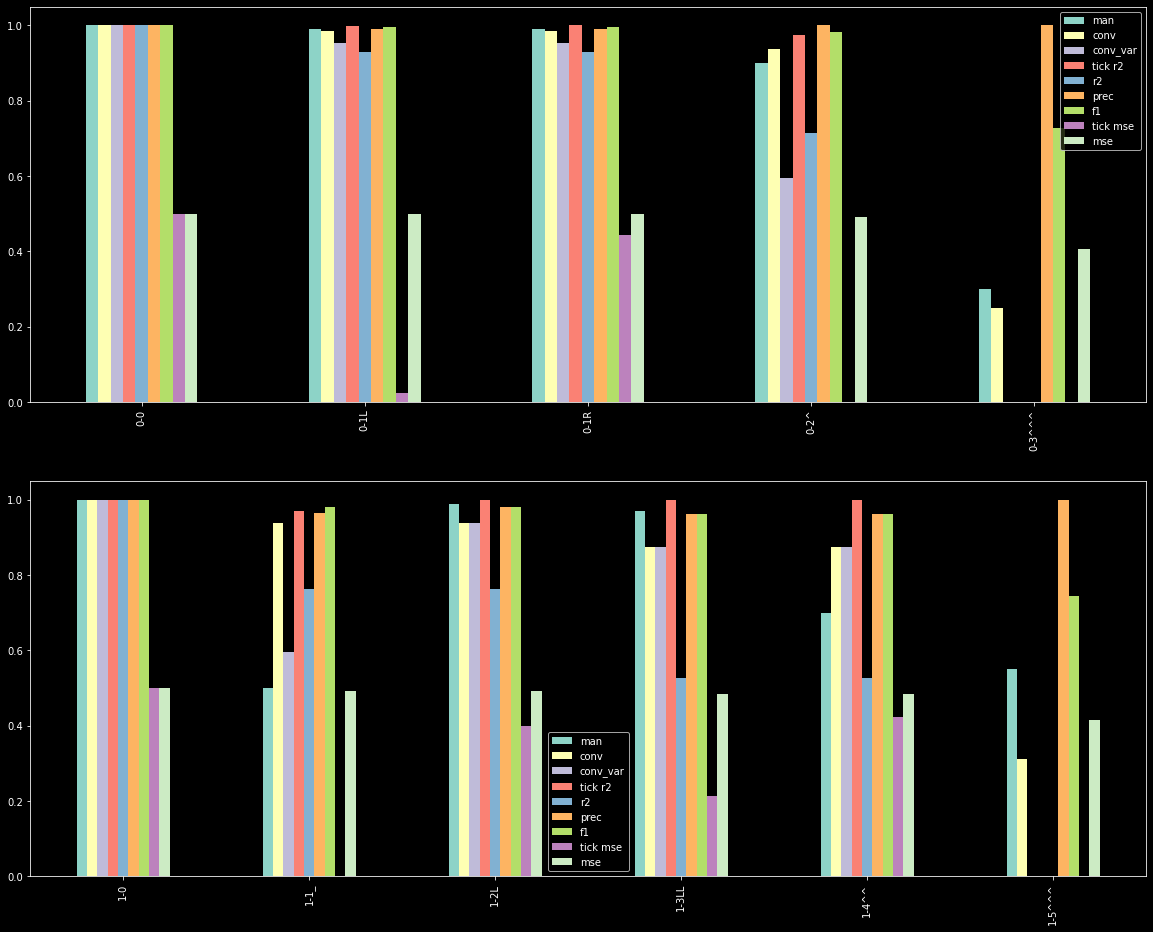

In [3]:
# Plot scores
score_dfs = [pd.DataFrame.from_dict(scores[name], orient='index', columns=score_names) for name in scores.keys()]
scores_rows = len(scores.values())

f2, axs2  = plt.subplots(scores_rows, 1, squeeze=False, figsize=(20,16))

for i in range(len(score_dfs)):
    axs = axs2[:,0]
    score_dfs[i].plot.bar(ax=axs[i])
    display(score_dfs[i])